In [3]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import FastICA
from pandas import DataFrame, Series
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import io

%matplotlib inline
np.set_printoptions(precision=3 , suppress= True)

In [4]:
#importing the file and defining the columns I am going to work with:
columnsName_file = ['YYMMMDD', '__east(m)', '_north(m)']

filePath1 = './brse.txt'
station1 = pd.read_csv(filePath1, usecols = columnsName_file, delimiter = '\s+')

filePath2 = './mpra.txt'
station2 = pd.read_csv(filePath2, usecols = columnsName_file, delimiter = '\s+')

filePath3 = './pord.txt'
station3 = pd.read_csv(filePath3, usecols = columnsName_file, delimiter = '\s+')

print('BRSE', station1)
print('MPRA', station2)
print('PORD', station3)

BRSE       YYMMMDD  __east(m)  _north(m)
0     10JUN12  -0.602588   0.618030
1     10JUN13  -0.604064   0.621100
2     10JUN14  -0.603825   0.617972
3     10JUN15  -0.602366   0.617000
4     10JUN16  -0.603291   0.621471
...       ...        ...        ...
3053  19JUN30  -0.428062   0.779092
3054  19JUL01  -0.427384   0.780153
3055  19JUL02  -0.429304   0.778882
3056  19JUL03  -0.429537   0.778300
3057  19JUL04  -0.427183   0.779518

[3058 rows x 3 columns]
MPRA       YYMMMDD  __east(m)  _north(m)
0     02AUG09  -0.044150   0.472504
1     02AUG10  -0.047696   0.473255
2     02AUG11  -0.048787   0.472202
3     02AUG12  -0.049708   0.473231
4     02AUG13  -0.049089   0.471035
...       ...        ...        ...
7554  24JAN02   0.391477   0.834859
7555  24JAN03   0.395028   0.837236
7556  24JAN04   0.392856   0.836844
7557  24JAN05   0.391546   0.835170
7558  24JAN06   0.391431   0.834913

[7559 rows x 3 columns]
PORD       YYMMMDD  __east(m)  _north(m)
0     06AUG25  -0.516736   0.502569

In [5]:
#changing the dtype of 'YYMMMDD':
station1['YYMMMDD'] = pd.to_datetime(station1['YYMMMDD'], format='%y%b%d')
station2['YYMMMDD'] = pd.to_datetime(station2['YYMMMDD'], format='%y%b%d')
station3['YYMMMDD'] = pd.to_datetime(station3['YYMMMDD'], format='%y%b%d')

#setting 'YYMMMDD' as index:
station1.set_index('YYMMMDD', inplace = True)
station2.set_index('YYMMMDD', inplace = True)
station3.set_index('YYMMMDD', inplace = True)


print('BRSE', station1)
print('MPRA', station2)
print('PORD', station3)

BRSE             __east(m)  _north(m)
YYMMMDD                         
2010-06-12  -0.602588   0.618030
2010-06-13  -0.604064   0.621100
2010-06-14  -0.603825   0.617972
2010-06-15  -0.602366   0.617000
2010-06-16  -0.603291   0.621471
...               ...        ...
2019-06-30  -0.428062   0.779092
2019-07-01  -0.427384   0.780153
2019-07-02  -0.429304   0.778882
2019-07-03  -0.429537   0.778300
2019-07-04  -0.427183   0.779518

[3058 rows x 2 columns]
MPRA             __east(m)  _north(m)
YYMMMDD                         
2002-08-09  -0.044150   0.472504
2002-08-10  -0.047696   0.473255
2002-08-11  -0.048787   0.472202
2002-08-12  -0.049708   0.473231
2002-08-13  -0.049089   0.471035
...               ...        ...
2024-01-02   0.391477   0.834859
2024-01-03   0.395028   0.837236
2024-01-04   0.392856   0.836844
2024-01-05   0.391546   0.835170
2024-01-06   0.391431   0.834913

[7559 rows x 2 columns]
PORD             __east(m)  _north(m)
YYMMMDD                         
2006-08-25 

fig=plt.figure(figsize=(40,10))

plt.subplot(411) 
plt.plot(station1.index, station1['__east(m)'], label='brse - east(m)') 
plt.legend(loc='best')
plt.xticks(fontsize=20)
#plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=20)

plt.subplot(412) 
plt.plot(station2.index, station2['__east(m)'], label='mpra - east(m)') 
plt.legend(loc='best') 
plt.xticks(fontsize=20)
plt.xlim(pd.Timestamp('2010-01-15'), pd.Timestamp('2020-01-15'))
plt.yticks(fontsize=20)

plt.subplot(413) 
plt.plot(station1.index, station1['_north(m)'], label='brse - north(m)') 
plt.legend(loc='best')
plt.xticks(fontsize=20)
#plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=20)

plt.subplot(414) 
plt.plot(station2.index, station2['_north(m)'], label='mpra - north(m)') 
plt.legend(loc='best') 
plt.xticks(fontsize=20)
plt.xlim(pd.Timestamp('2010-01-15'), pd.Timestamp('2020-01-15'))
plt.yticks(fontsize=20)

plt.tight_layout()

fig=plt.figure(figsize=(40,10))
diff = []

for i in range(1, len(station1['__east(m)'])):
 value = station1['__east(m)'][i] - station1['__east(m)'][i - 1]
 diff.append(value)

diff.insert(0,0)

brse_east = pd.DataFrame(diff, index=station1.index, columns=['east(m)'])
plt.plot(brse_east['east(m)'])
plt.show()

brse_east1 = station1['__east(m)'] - station1['__east(m)'].shift()
brse_east1

brse_east1.dropna(inplace=True)
brse_east1

In [6]:
#getting the linear model to substract from the original time series:
#BRSE

x1 = np.arange(len(station1)).reshape(-1,1)

#linear trend - EAST
brse_yE = station1['__east(m)'].values.reshape(-1,1)
brse_linearModelE = LinearRegression().fit(x1,brse_yE)
brse_regressionLineE = brse_linearModelE.predict(x1)

brse_detrendedLinear_east = station1['__east(m)'].values - brse_regressionLineE.flatten()
print(f"BRSE - Linear Detrended (east): {brse_detrendedLinear_east}")

#linear trend - NORTH
brse_yN = station1['_north(m)'].values.reshape(-1,1)
brse_linearModelN = LinearRegression().fit(x1,brse_yN)
brse_regressionLineN = brse_linearModelN.predict(x1)

brse_detrendedLinear_north = station1['_north(m)'].values - brse_regressionLineN.flatten()
print(f"BRSE - Linear Detrended (north): {brse_detrendedLinear_north}")

#changig the results to a 'DataFrame' format:
linearDetrended_brseE = pd.DataFrame(brse_detrendedLinear_east, index=station1.index, columns=['east(m)'])
linearDetrended_brseN = pd.DataFrame(brse_detrendedLinear_north, index=station1.index, columns=['north(m)'])

print(f"BRSE - Linear Detrended (east): {linearDetrended_brseE}")
print(f"BRSE - Linear Detrended (north): {linearDetrended_brseN}")

BRSE - Linear Detrended (east): [-0.002 -0.003 -0.003 ... -0.008 -0.009 -0.006]
BRSE - Linear Detrended (north): [0.003 0.006 0.003 ... 0.014 0.013 0.014]
BRSE - Linear Detrended (east):              east(m)
YYMMMDD             
2010-06-12 -0.001771
2010-06-13 -0.003306
2010-06-14 -0.003125
2010-06-15 -0.001725
2010-06-16 -0.002709
...              ...
2019-06-30 -0.006959
2019-07-01 -0.006340
2019-07-02 -0.008319
2019-07-03 -0.008611
2019-07-04 -0.006316

[3058 rows x 1 columns]
BRSE - Linear Detrended (north):             north(m)
YYMMMDD             
2010-06-12  0.002702
2010-06-13  0.005723
2010-06-14  0.002546
2010-06-15  0.001525
2010-06-16  0.005947
...              ...
2019-06-30  0.014099
2019-07-01  0.015111
2019-07-02  0.013791
2019-07-03  0.013160
2019-07-04  0.014329

[3058 rows x 1 columns]


In [7]:
#getting the linear model to substract from the original time series:
#MPRA

x2 = np.arange(len(station2)).reshape(-1,1)

#linear trend - EAST
mpra_yE = station2['__east(m)'].values.reshape(-1,1)
mpra_linearModelE = LinearRegression().fit(x2,mpra_yE)
mpra_regressionLineE = mpra_linearModelE.predict(x2)

mpra_detrendedLinear_east = station2['__east(m)'].values - mpra_regressionLineE.flatten()
print(f"MPRA - Linear Detrended (east): {mpra_detrendedLinear_east}")

#linear trend - NORTH
mpra_yN = station2['_north(m)'].values.reshape(-1,1)
mpra_linearModelN = LinearRegression().fit(x2,mpra_yN)
mpra_regressionLineN = mpra_linearModelN.predict(x2)

mpra_detrendedLinear_north = station2['_north(m)'].values - mpra_regressionLineN.flatten()
print(f"MPRA - Linear Detrended (north): {mpra_detrendedLinear_north}")

#changig the results to a 'DataFrame' format:
linearDetrended_mpraE = pd.DataFrame(mpra_detrendedLinear_east, index=station2.index, columns=['east(m)'])
linearDetrended_mpraN = pd.DataFrame(mpra_detrendedLinear_north, index=station2.index, columns=['north(m)'])

print(f"MPRA - Linear Detrended (east): {linearDetrended_mpraE}")
print(f"MPRA - Linear Detrended (north): {linearDetrended_mpraN}")

MPRA - Linear Detrended (east): [-0.002 -0.006 -0.007 ... -0.001 -0.002 -0.002]
MPRA - Linear Detrended (north): [-0.005 -0.004 -0.005 ...  0.001 -0.001 -0.001]
MPRA - Linear Detrended (east):              east(m)
YYMMMDD             
2002-08-09 -0.002374
2002-08-10 -0.005978
2002-08-11 -0.007127
2002-08-12 -0.008105
2002-08-13 -0.007544
...              ...
2024-01-02 -0.002205
2024-01-03  0.001289
2024-01-04 -0.000941
2024-01-05 -0.002309
2024-01-06 -0.002481

[7559 rows x 1 columns]
MPRA - Linear Detrended (north):             north(m)
YYMMMDD             
2002-08-09 -0.005007
2002-08-10 -0.004304
2002-08-11 -0.005404
2002-08-12 -0.004423
2002-08-13 -0.006666
...              ...
2024-01-02 -0.001067
2024-01-03  0.001263
2024-01-04  0.000823
2024-01-05 -0.000898
2024-01-06 -0.001202

[7559 rows x 1 columns]


In [8]:
#getting the linear model to substract from the original time series:
#PORD

x3 = np.arange(len(station3)).reshape(-1,1)

#Linear trend - EAST
pord_YE = station3['__east(m)'].values.reshape(-1,1)
pord_linearModelE = LinearRegression().fit(x3,pord_YE)
pord_regressionLineE = pord_linearModelE.predict(x3)

pord_detrendedLinear_east = station3['__east(m)'].values - pord_regressionLineE.flatten()
print(f"PORD - Linear Detrended (east): {pord_detrendedLinear_east}")

#linear trend - NORTH
pord_yN = station3['_north(m)'].values.reshape(-1,1)
pord_linearModelN = LinearRegression().fit(x3,pord_yN)
pord_regressionLineN = pord_linearModelN.predict(x3)

pord_detrendedLinear_north = station3['_north(m)'].values - pord_regressionLineN.flatten()
print(f"MPRA - Linear Detrended (north): {pord_detrendedLinear_north}")

#changig the results to a 'DataFrame' format:
linearDetrended_pordE = pd.DataFrame(pord_detrendedLinear_east, index=station3.index, columns=['east(m)'])
linearDetrended_pordN = pd.DataFrame(pord_detrendedLinear_north, index=station3.index, columns=['north(m)'])

print(f"MPRA - Linear Detrended (east): {linearDetrended_pordE}")
print(f"MPRA - Linear Detrended (north): {linearDetrended_pordN}")

PORD - Linear Detrended (east): [ 0.001 -0.    -0.001 ...  0.002  0.     0.002]
MPRA - Linear Detrended (north): [ 0.003  0.001  0.002 ...  0.002 -0.     0.002]
MPRA - Linear Detrended (east):              east(m)
YYMMMDD             
2006-08-25  0.001072
2006-08-26 -0.000205
2006-08-27 -0.000694
2006-08-28  0.000734
2006-08-29 -0.000476
...              ...
2022-12-27  0.002888
2022-12-28  0.000563
2022-12-29  0.001705
2022-12-30  0.000466
2022-12-31  0.001662

[5874 rows x 1 columns]
MPRA - Linear Detrended (north):             north(m)
YYMMMDD             
2006-08-25  0.003473
2006-08-26  0.000621
2006-08-27  0.001953
2006-08-28  0.002178
2006-08-29  0.003656
...              ...
2022-12-27  0.003256
2022-12-28  0.003090
2022-12-29  0.001658
2022-12-30 -0.000461
2022-12-31  0.001728

[5874 rows x 1 columns]


In [9]:
#selecting the outliers and removing them:
limiarZ = 2.0

#BRSE
#EAST
brseE_linearDet_noOut = linearDetrended_brseE[(np.abs(linearDetrended_brseE-linearDetrended_brseE.mean()) 
                                              < limiarZ*linearDetrended_brseE.std())]
#NORTH
brseN_linearDet_noOut = linearDetrended_brseN[(np.abs(linearDetrended_brseN-linearDetrended_brseN.mean()) 
                                              < limiarZ*linearDetrended_brseN.std())]

print(f"BRSE - Linear Detrended Outliers Removed (east): {brseE_linearDet_noOut}")
print(f"BRSE - Linear Detrended Outliers Removed (north): {brseN_linearDet_noOut}")

#MPRA
#EAST
mpraE_linearDet_noOut = linearDetrended_mpraE[(np.abs(linearDetrended_mpraE-linearDetrended_mpraE.mean()) 
                                              < limiarZ*linearDetrended_mpraE.std())]
#NORTH
mpraN_linearDet_noOut = linearDetrended_mpraN[(np.abs(linearDetrended_mpraN-linearDetrended_mpraN.mean()) 
                                              < limiarZ*linearDetrended_mpraN.std())]

print(f"MPRA - Linear Detrended Outliers Removed (east): {mpraE_linearDet_noOut}")
print(f"MPRA - Linear Detrended Outliers Removed (north): {mpraN_linearDet_noOut}")

#PORD
#EAST
pordE_linearDet_noOut = linearDetrended_pordE[(np.abs(linearDetrended_pordE-linearDetrended_pordE.mean()) 
                                              < limiarZ*linearDetrended_pordE.std())]
#NORTH
pordN_linearDet_noOut = linearDetrended_pordN[(np.abs(linearDetrended_pordN-linearDetrended_pordN.mean()) 
                                              < limiarZ*linearDetrended_pordN.std())]

print(f"PORD - Linear Detrended Outliers Removed (east): {pordE_linearDet_noOut}")
print(f"PORD - Linear Detrended Outliers Removed (north): {pordN_linearDet_noOut}")

BRSE - Linear Detrended Outliers Removed (east):              east(m)
YYMMMDD             
2010-06-12 -0.001771
2010-06-13 -0.003306
2010-06-14 -0.003125
2010-06-15 -0.001725
2010-06-16 -0.002709
...              ...
2019-06-30       NaN
2019-07-01       NaN
2019-07-02       NaN
2019-07-03       NaN
2019-07-04       NaN

[3058 rows x 1 columns]
BRSE - Linear Detrended Outliers Removed (north):             north(m)
YYMMMDD             
2010-06-12  0.002702
2010-06-13  0.005723
2010-06-14  0.002546
2010-06-15  0.001525
2010-06-16  0.005947
...              ...
2019-06-30       NaN
2019-07-01       NaN
2019-07-02       NaN
2019-07-03       NaN
2019-07-04       NaN

[3058 rows x 1 columns]
MPRA - Linear Detrended Outliers Removed (east):              east(m)
YYMMMDD             
2002-08-09 -0.002374
2002-08-10       NaN
2002-08-11       NaN
2002-08-12       NaN
2002-08-13       NaN
...              ...
2024-01-02 -0.002205
2024-01-03  0.001289
2024-01-04 -0.000941
2024-01-05 -0.002309
2024

In [10]:
#dropping the NaN values

#BRSE
brseE_linearDet_noOut.dropna(inplace=True)
brseN_linearDet_noOut.dropna(inplace=True)

print(f"BRSE - Linear Detrended Outliers Removed (east): {brseE_linearDet_noOut}")
print(f"BRSE - Linear Detrended Outliers Removed (north): {brseN_linearDet_noOut}")

#MPRA
mpraE_linearDet_noOut.dropna(inplace=True)
mpraN_linearDet_noOut.dropna(inplace=True)

print(f"MPRA - Linear Detrended Outliers Removed (east): {mpraE_linearDet_noOut}")
print(f"MPRA - Linear Detrended Outliers Removed (north): {mpraN_linearDet_noOut}")

#PORD
pordE_linearDet_noOut.dropna(inplace=True)
pordN_linearDet_noOut.dropna(inplace=True)

print(f"PORD - Linear Detrended Outliers Removed (east): {pordE_linearDet_noOut}")
print(f"PORD - Linear Detrended Outliers Removed (north): {pordN_linearDet_noOut}")

BRSE - Linear Detrended Outliers Removed (east):              east(m)
YYMMMDD             
2010-06-12 -0.001771
2010-06-13 -0.003306
2010-06-14 -0.003125
2010-06-15 -0.001725
2010-06-16 -0.002709
...              ...
2019-05-10 -0.003161
2019-05-18 -0.003452
2019-05-19 -0.004057
2019-05-20 -0.004523
2019-06-11 -0.003295

[2908 rows x 1 columns]
BRSE - Linear Detrended Outliers Removed (north):             north(m)
YYMMMDD             
2010-06-12  0.002702
2010-06-13  0.005723
2010-06-14  0.002546
2010-06-15  0.001525
2010-06-16  0.005947
...              ...
2018-12-02 -0.002587
2018-12-03 -0.001694
2018-12-04  0.000195
2018-12-05  0.000832
2019-01-18  0.007754

[2895 rows x 1 columns]
MPRA - Linear Detrended Outliers Removed (east):              east(m)
YYMMMDD             
2002-08-09 -0.002374
2002-08-18 -0.003028
2002-08-22 -0.003682
2002-08-23 -0.003592
2002-09-04 -0.003201
...              ...
2024-01-02 -0.002205
2024-01-03  0.001289
2024-01-04 -0.000941
2024-01-05 -0.002309
2024

stations = pd.concat([brseE_linearDet_noOut, mpraE_linearDet_noOut, pordE_linearDet_noOut], axis=1, keys=['brse', 'mpra', 'pord'])
stations = stations.loc['2011-01-15':'2018-07-15']
stations

stations['rolling_mean_stations'] = stations[['brse', 'mpra', 'pord']].mean(axis=1).rolling(8, min_periods=1).mean()
stations

In [57]:
del stations

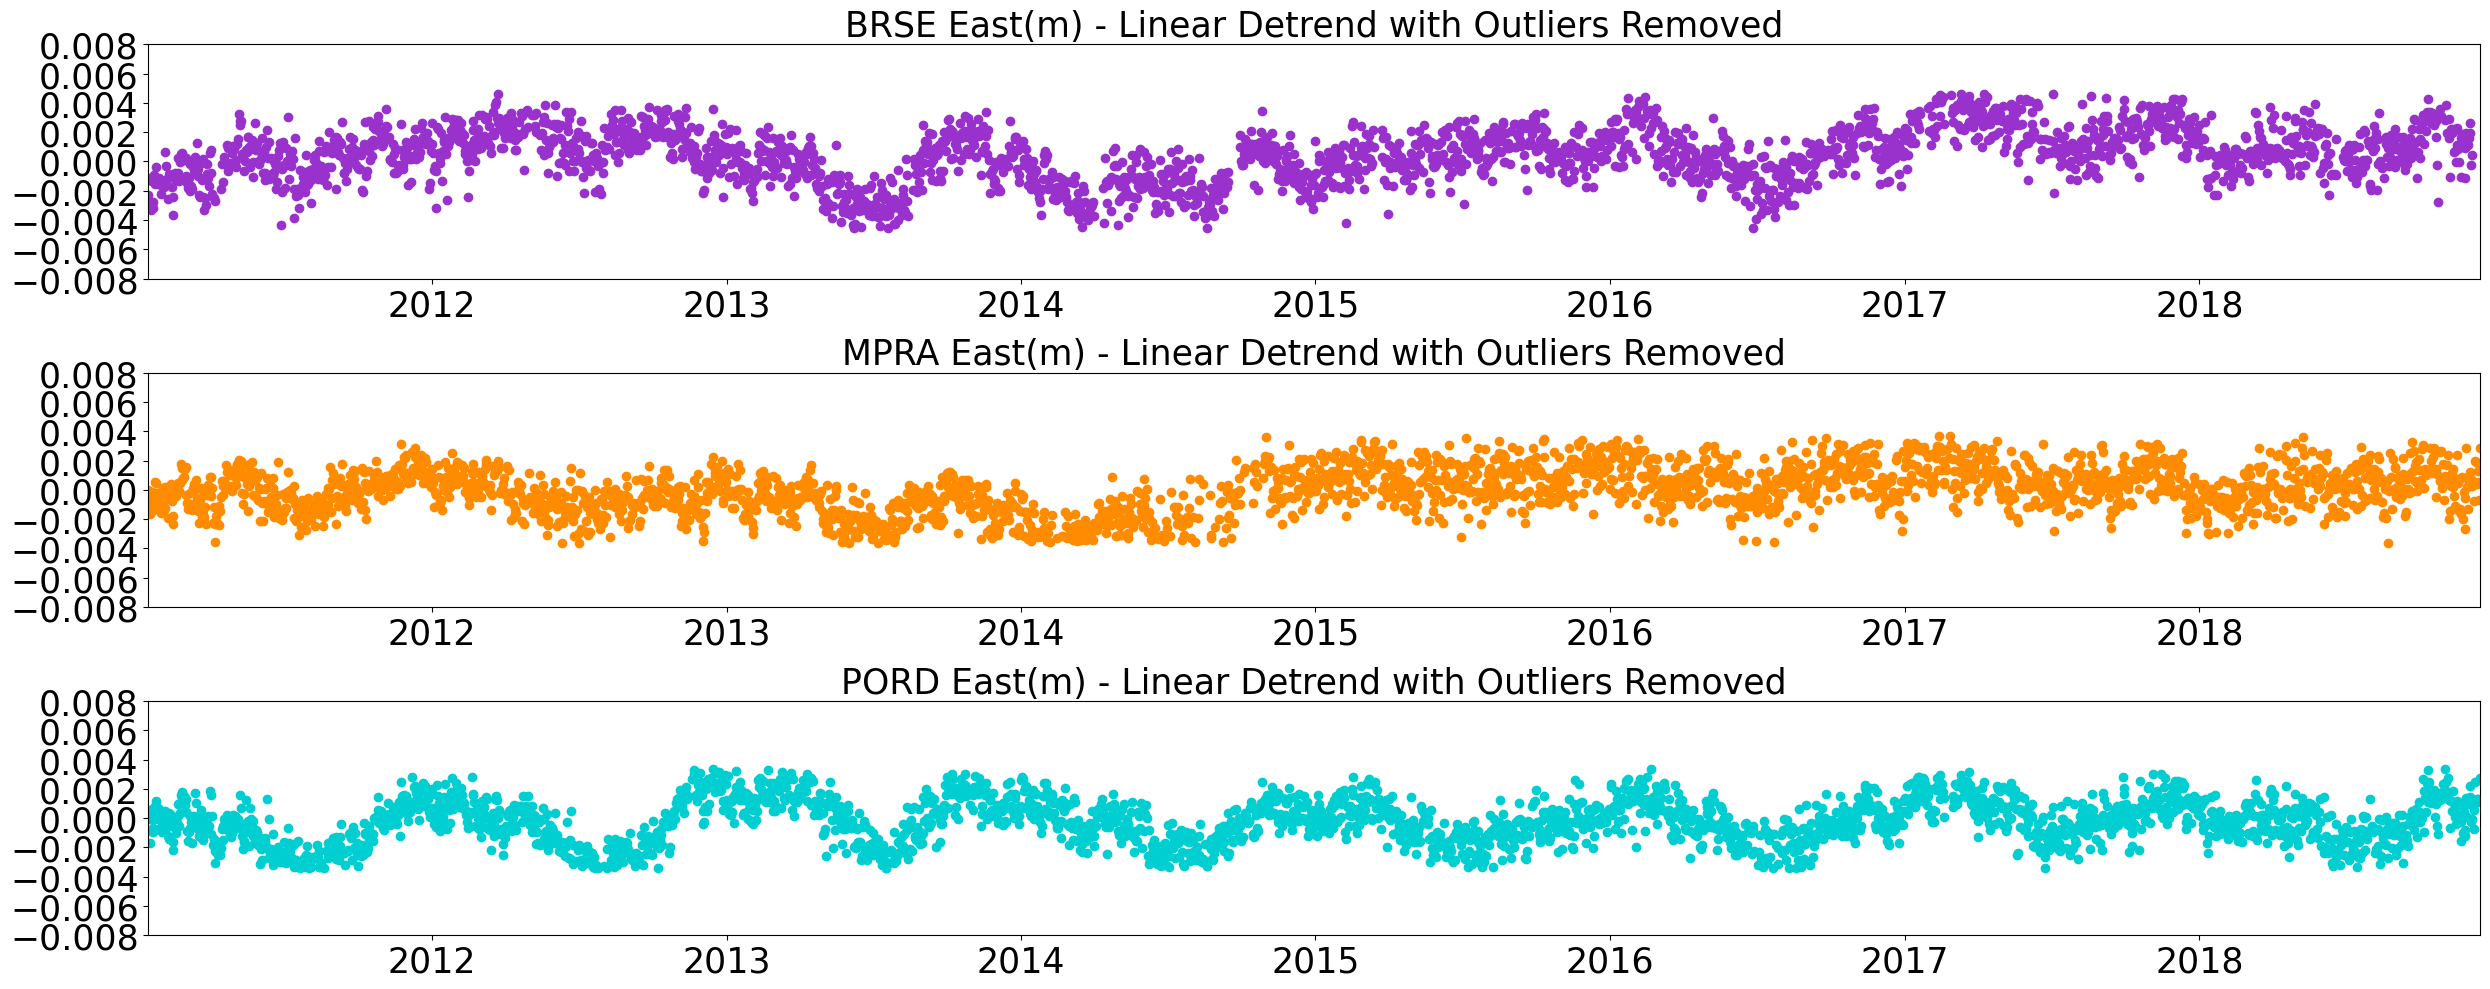

In [38]:
#comparison between EAST(m) - stations BRSE and MPRA:
fig=plt.figure(figsize=(25,10))

#BRSE
plt.subplot(3, 1, 1)
plt.plot(brseE_linearDet_noOut, 'o', color='darkorchid')
plt.title('BRSE East(m) - Linear Detrend with Outliers Removed', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(-0.008,0.008)
plt.xlim(pd.Timestamp('2011-01-15'), pd.Timestamp('2018-12-15'))

#MPRA
plt.subplot(3, 1, 2)
plt.plot(mpraE_linearDet_noOut, 'o', color='darkorange')
plt.title('MPRA East(m) - Linear Detrend with Outliers Removed', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(-0.008,0.008)
plt.xlim(pd.Timestamp('2011-01-15'), pd.Timestamp('2018-12-15'))

#PORD
plt.subplot(3, 1, 3)
plt.plot(pordE_linearDet_noOut, 'o', color='darkturquoise')
plt.title('PORD East(m) - Linear Detrend with Outliers Removed', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(-0.008,0.008)
plt.xlim(pd.Timestamp('2011-01-15'), pd.Timestamp('2018-12-15'))

fl = 'brse_mpra_pord_east.svg'
f = io.BytesIO()
#plt.savefig(fl, format="svg")

plt.tight_layout()
plt.show()

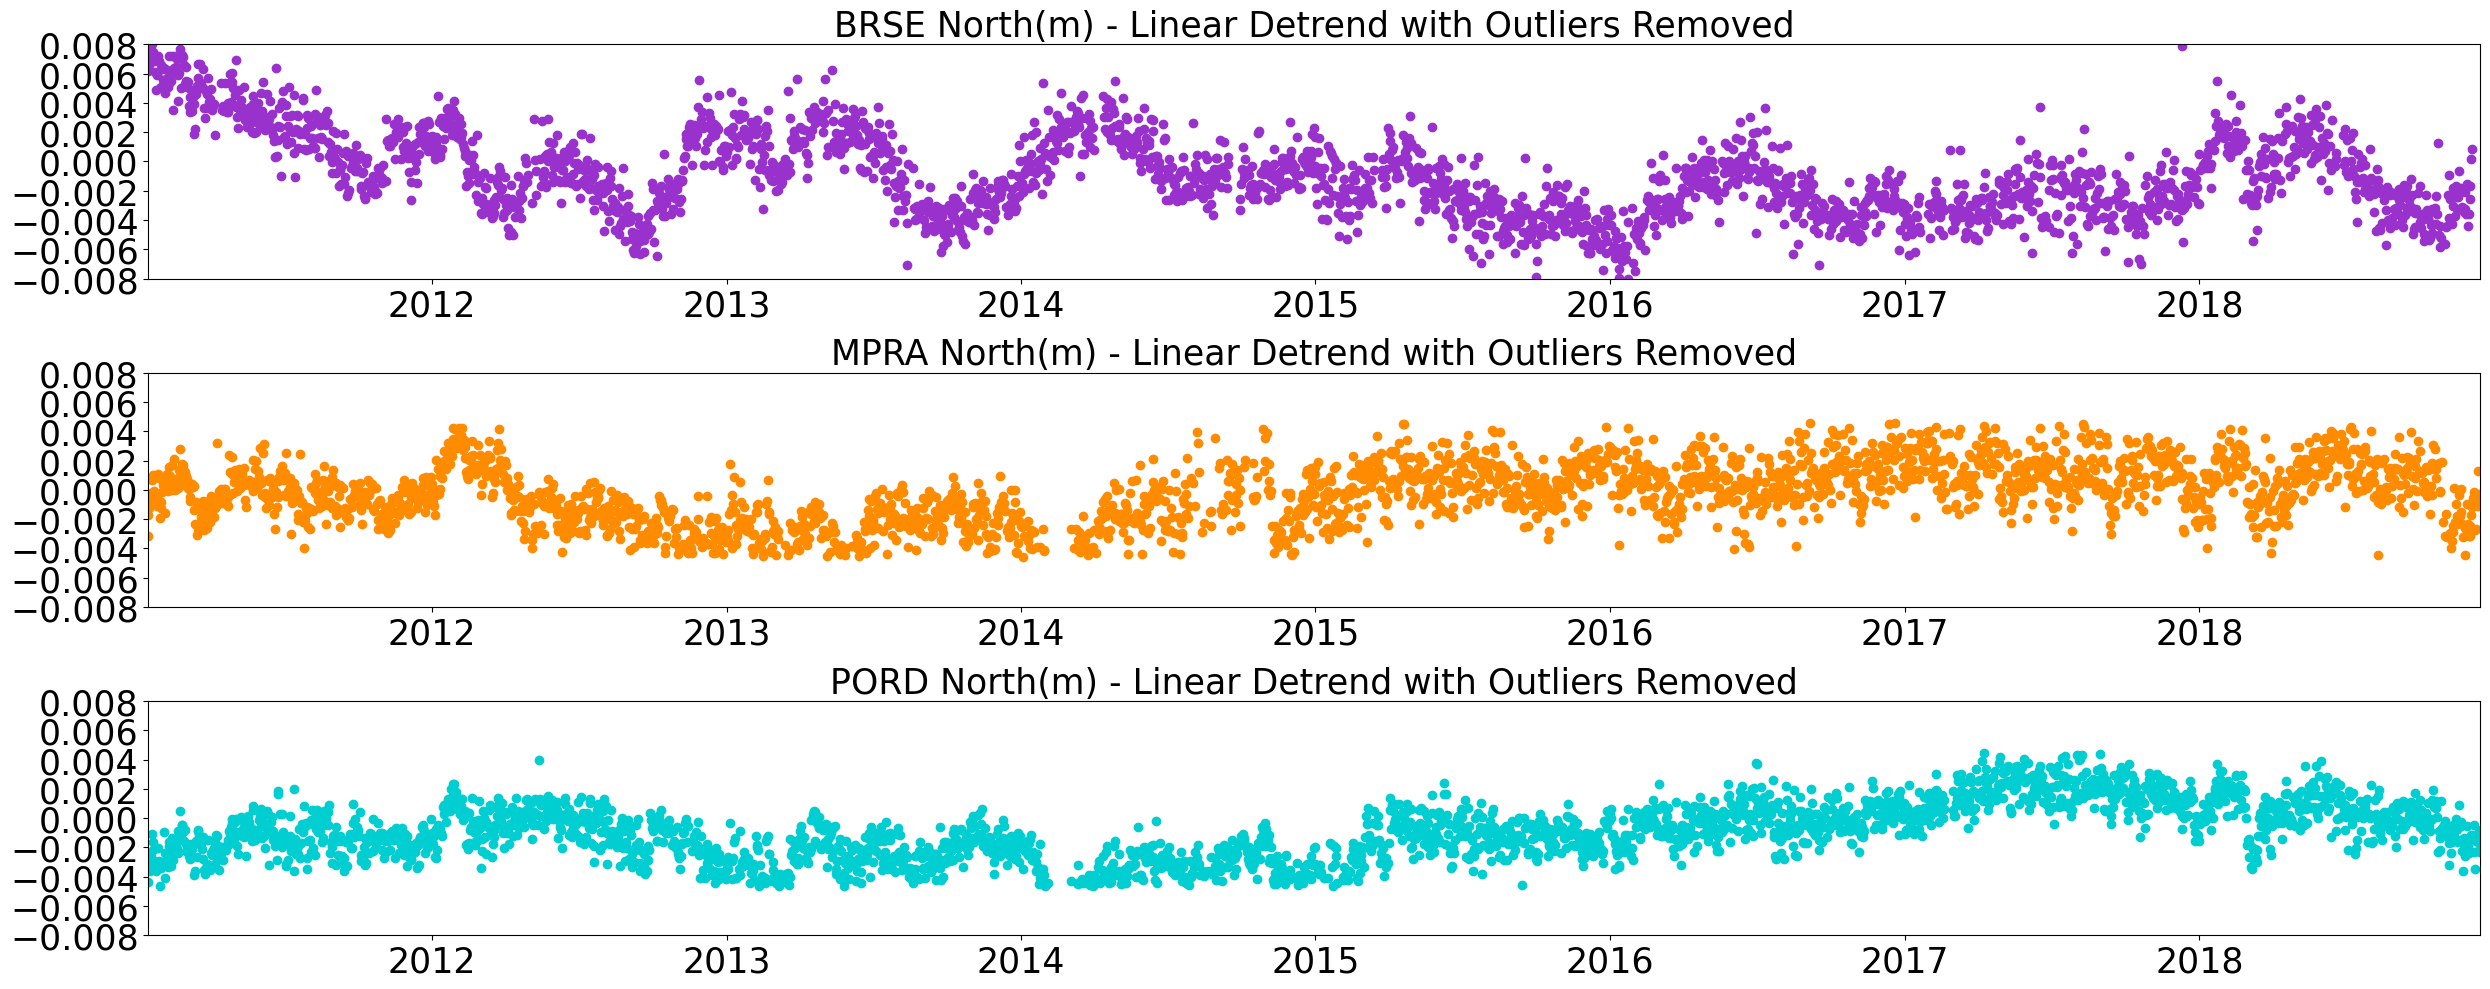

In [54]:
#comparison between NORTH(m) - stations BRSE and MPRA:
fig=plt.figure(figsize=(25,10))

#BRSE
plt.subplot(3, 1, 1)
plt.plot(brseN_linearDet_noOut, 'o', color='darkorchid')
plt.title('BRSE North(m) - Linear Detrend with Outliers Removed', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(-0.008,0.008)
plt.xlim(pd.Timestamp('2011-01-15'), pd.Timestamp('2018-12-15'))

#MPRA
plt.subplot(3, 1, 2)
plt.plot(mpraN_linearDet_noOut, 'o', color='darkorange')
plt.title('MPRA North(m) - Linear Detrend with Outliers Removed', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(-0.008,0.008)
plt.xlim(pd.Timestamp('2011-01-15'), pd.Timestamp('2018-12-15'))

#PORD
plt.subplot(3, 1, 3)
plt.plot(pordN_linearDet_noOut, 'o', color='darkturquoise')
plt.title('PORD North(m) - Linear Detrend with Outliers Removed', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(-0.008,0.008)
plt.xlim(pd.Timestamp('2011-01-15'), pd.Timestamp('2018-12-15'))

fl = 'brse_mpra_north.svg'
f = io.BytesIO()
#plt.savefig(fl, format="svg")

plt.tight_layout()
plt.show()

In [40]:
#BRSE
brse_rolmeanE = brseE_linearDet_noOut.rolling(8, min_periods=1).mean()
brse_rolmeanN = brseN_linearDet_noOut.rolling(8, min_periods=1).mean()
print(f"Rolling Mean BRSE east: {brse_rolmeanE}")
print(f"Rolling Mean BRSE north: {brse_rolmeanN}")

#MPRA
mpra_rolmeanE = mpraE_linearDet_noOut.rolling(8, min_periods=1).mean()
mpra_rolmeanN = mpraN_linearDet_noOut.rolling(8, min_periods=1).mean()
print(f"Rolling Mean MPRA east: {mpra_rolmeanE}")
print(f"Rolling Mean MPRA north: {mpra_rolmeanN}")

#PORD
pord_rolmeanE = pordE_linearDet_noOut.rolling(8, min_periods=1).mean()
pord_rolmeanN = pordN_linearDet_noOut.rolling(8, min_periods=1).mean()
print(f"Rolling Mean MPRA east: {pord_rolmeanE}")
print(f"Rolling Mean MPRA north: {pord_rolmeanN}")

Rolling Mean BRSE east:              east(m)
YYMMMDD             
2010-06-12 -0.001771
2010-06-13 -0.002538
2010-06-14 -0.002734
2010-06-15 -0.002482
2010-06-16 -0.002527
...              ...
2019-05-10 -0.003268
2019-05-18 -0.003290
2019-05-19 -0.003440
2019-05-20 -0.003760
2019-06-11 -0.003716

[2908 rows x 1 columns]
Rolling Mean BRSE north:             north(m)
YYMMMDD             
2010-06-12  0.002702
2010-06-13  0.004212
2010-06-14  0.003657
2010-06-15  0.003124
2010-06-16  0.003688
...              ...
2018-12-02 -0.003067
2018-12-03 -0.002846
2018-12-04 -0.002415
2018-12-05 -0.002052
2019-01-18 -0.000631

[2895 rows x 1 columns]
Rolling Mean MPRA east:              east(m)
YYMMMDD             
2002-08-09 -0.002374
2002-08-18 -0.002701
2002-08-22 -0.003028
2002-08-23 -0.003169
2002-09-04 -0.003175
...              ...
2024-01-02 -0.000980
2024-01-03 -0.000636
2024-01-04 -0.000699
2024-01-05 -0.000826
2024-01-06 -0.001027

[7220 rows x 1 columns]
Rolling Mean MPRA north:         

In [41]:
#BRSE
#EAST
brseE_linearDet_noOut.dropna(inplace=True)
brse_rolmeanE.dropna(inplace=True)
#NORTH
brseN_linearDet_noOut.dropna(inplace=True)
brse_rolmeanN.dropna(inplace=True)

#MPRA 
#EAST
mpraE_linearDet_noOut.dropna(inplace=True)
mpra_rolmeanE.dropna(inplace=True)
#NORTH
mpraN_linearDet_noOut.dropna(inplace=True)
mpra_rolmeanN.dropna(inplace=True)

#PORD
#EAST
pordE_linearDet_noOut.dropna(inplace=True)
pord_rolmeanE.dropna(inplace=True)
#NORTH
pordN_linearDet_noOut.dropna(inplace=True)
pord_rolmeanN.dropna(inplace=True)

In [42]:
#Mean Squared Error (MSE) and R-Squared Value (R2)

#BRSE
#EAST
brseE_mse = mean_squared_error(brseE_linearDet_noOut['east(m)'], brse_rolmeanE)
print(f"BRSE east - Mean Squared Error: {brseE_mse}")
brseE_r2 =r2_score(brseE_linearDet_noOut['east(m)'], brse_rolmeanE)
print(f"BRSE east - R-Squared Value: {brseE_r2}")
#NORTH
brseN_mse = mean_squared_error(brseN_linearDet_noOut['north(m)'], brse_rolmeanN)
print(f"BRSE north - Mean Squared Error: {brseN_mse}")
brseN_r2 =r2_score(brseN_linearDet_noOut['north(m)'], brse_rolmeanN)
print(f"BRSE north - R-Squared Value: {brseN_r2}")

#MPRA
#EAST
mpraE_mse = mean_squared_error(mpraE_linearDet_noOut['east(m)'], mpra_rolmeanE)
print(f"MPRA east - Mean Squared Error: {mpraE_mse}")
mpraE_r2 =r2_score(mpraE_linearDet_noOut['east(m)'], mpra_rolmeanE)
print(f"MPRA east - R-Squared Value: {mpraE_r2}")
#NORTH
mpraN_mse = mean_squared_error(mpraN_linearDet_noOut['north(m)'], mpra_rolmeanN)
print(f"MPRA north - Mean Squared Error: {mpraN_mse}")
mpraN_r2 =r2_score(mpraN_linearDet_noOut['north(m)'], mpra_rolmeanN)
print(f"MPRA north - R-Squared Value: {mpraN_r2}")

#PORD
#EAST
pordE_mse = mean_squared_error(pordE_linearDet_noOut['east(m)'], pord_rolmeanE)
print(f"PORD east - Mean Squared Error: {pordE_mse}")
pordE_r2 =r2_score(pordE_linearDet_noOut['east(m)'], pord_rolmeanE)
print(f"PORD east - R-Squared Value: {pordE_r2}")
#NORTH
pordN_mse = mean_squared_error(pordN_linearDet_noOut['north(m)'], pord_rolmeanN)
print(f"PORD north - Mean Squared Error: {pordN_mse}")
pordN_r2 =r2_score(pordN_linearDet_noOut['north(m)'], pord_rolmeanN)
print(f"PORD north - R-Squared Value: {pordN_r2}")

BRSE east - Mean Squared Error: 1.0830808434083903e-06
BRSE east - R-Squared Value: 0.6913391197287502
BRSE north - Mean Squared Error: 1.4857105043399556e-06
BRSE north - R-Squared Value: 0.8148455576786995
MPRA east - Mean Squared Error: 1.056976884396495e-06
MPRA east - R-Squared Value: 0.5750665267288414
MPRA north - Mean Squared Error: 1.3719436772804686e-06
MPRA north - R-Squared Value: 0.6436150553181348
PORD east - Mean Squared Error: 8.024498285127342e-07
PORD east - R-Squared Value: 0.6526477315431516
PORD north - Mean Squared Error: 9.022252416232406e-07
PORD north - R-Squared Value: 0.7896020917352033


In [126]:
brse_rolmeanE.rename(columns={'east(m)':'brse_east(m)'}, inplace=True)
pord_rolmeanE.rename(columns={'east(m)':'pord_east(m)'}, inplace=True)
mpra_rolmeanE.rename(columns={'east(m)':'mpra_east(m)'}, inplace=True)

print(brse_rolmeanE)
print(pord_rolmeanE)
print(mpra_rolmeanE)

            brse_east(m)
YYMMMDD                 
2010-06-12     -0.001771
2010-06-13     -0.002538
2010-06-14     -0.002734
2010-06-15     -0.002482
2010-06-16     -0.002527
...                  ...
2019-05-10     -0.003268
2019-05-18     -0.003290
2019-05-19     -0.003440
2019-05-20     -0.003760
2019-06-11     -0.003716

[2908 rows x 1 columns]
            pord_east(m)
YYMMMDD                 
2006-08-25      0.001072
2006-08-26      0.000433
2006-08-27      0.000058
2006-08-28      0.000227
2006-08-29      0.000086
...                  ...
2022-12-27      0.001897
2022-12-28      0.001716
2022-12-29      0.001963
2022-12-30      0.001877
2022-12-31      0.001792

[5615 rows x 1 columns]
            mpra_east(m)
YYMMMDD                 
2002-08-09     -0.002374
2002-08-18     -0.002701
2002-08-22     -0.003028
2002-08-23     -0.003169
2002-09-04     -0.003175
...                  ...
2024-01-02     -0.000980
2024-01-03     -0.000636
2024-01-04     -0.000699
2024-01-05     -0.000826


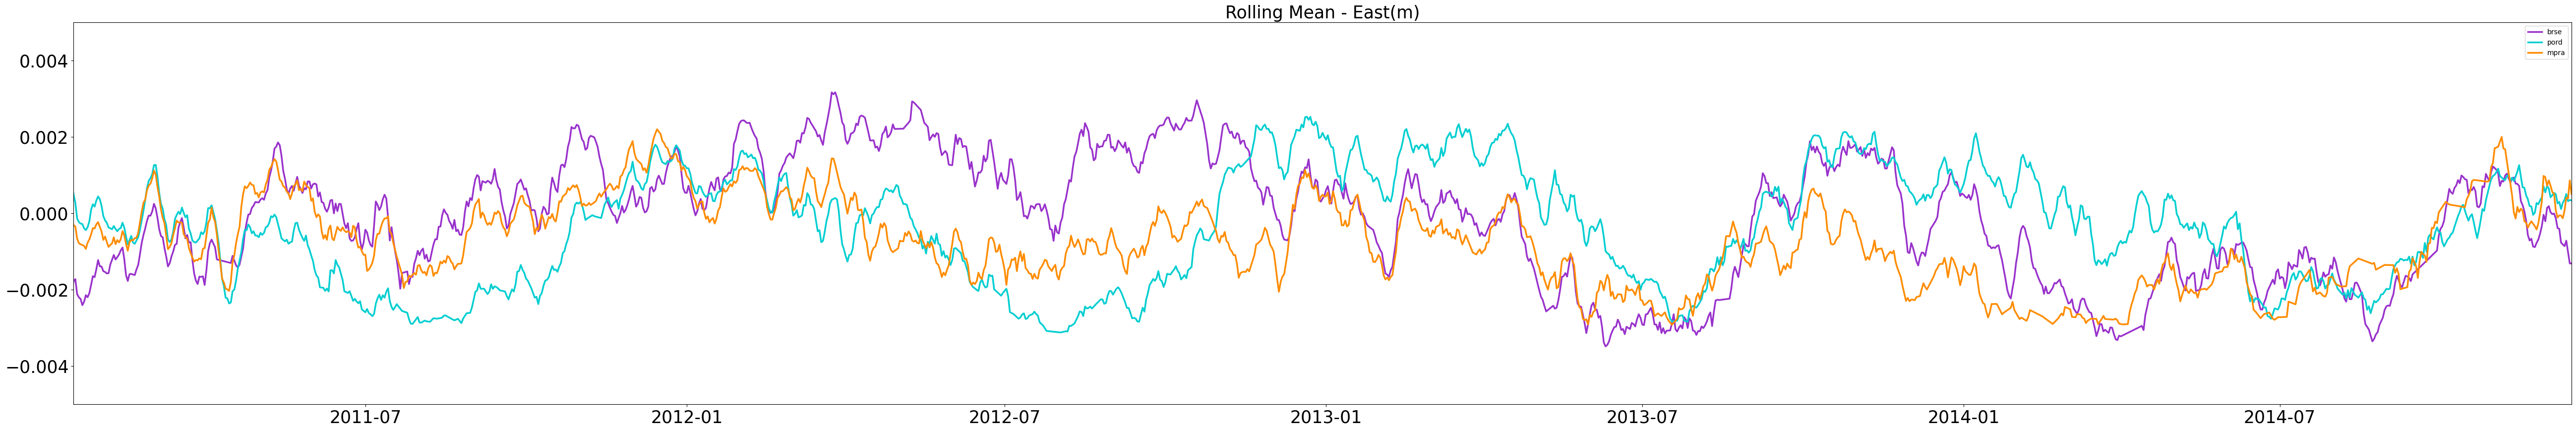

In [258]:
fig=plt.figure(figsize=(65,10))
plt.title('Rolling Mean - East(m)', fontsize = 25)

plt.plot(brse_rolmeanE, color='darkorchid', label='brse', lw=2.5)
plt.plot(pord_rolmeanE, color='darkturquoise', label='pord', lw=2.5)
plt.plot(mpra_rolmeanE, color='darkorange', label='mpra', lw=2.5)


plt.xlim(pd.Timestamp('2011-01-15'), pd.Timestamp('2014-12-15'))
plt.legend(loc='best')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(-0.005,0.005)

fl = 'brse_pord_3east.svg'
f = io.BytesIO()
#plt.savefig(fl, format="svg")

plt.show()

In [217]:
stations = pd.concat([brse_rolmeanE, pord_rolmeanE, mpra_rolmeanE], axis=1)

In [218]:
stations = stations.loc['2011-01-15':'2018-07-15']
stations

,brse_east(m),pord_east(m),mpra_east(m)
YYMMMDD,,,
2011-01-15,-0.001773,0.000490,-0.000314
2011-01-16,-0.001722,0.000275,-0.000344
2011-01-17,-0.002112,-0.000131,-0.000662
2011-01-18,-0.002197,-0.000227,-0.000777
2011-01-19,-0.002242,-0.000266,-0.000810
...,...,...,...
2018-07-11,0.000316,-0.001799,0.000251
2018-07-12,0.000399,-0.001707,0.000226
2018-07-13,0.000273,-0.001650,0.000338


In [269]:
stations['rolling_mean_stations'] = stations[['brse_east(m)', 'pord_east(m)', 'mpra_east(m)']].mean(axis=1).rolling(8, min_periods=1).mean()
stations

,brse_east(m),pord_east(m),mpra_east(m),rolling_mean_stations
YYMMMDD,,,,
2011-01-15,-0.001773,0.000490,-0.000314,-0.000532
2011-01-16,-0.001722,0.000275,-0.000344,-0.000565
2011-01-17,-0.002112,-0.000131,-0.000662,-0.000699
2011-01-18,-0.002197,-0.000227,-0.000777,-0.000791
2011-01-19,-0.002242,-0.000266,-0.000810,-0.000854
...,...,...,...,...
2018-07-11,0.000316,-0.001799,0.000251,-0.000405
2018-07-12,0.000399,-0.001707,0.000226,-0.000384
2018-07-13,0.000273,-0.001650,0.000338,-0.000368


In [270]:
print(stations.isnull().sum())

brse_east(m)             193
pord_east(m)             127
mpra_east(m)             176
rolling_mean_stations      0
dtype: int64


In [239]:
pd.options.mode.copy_on_write = True

stations_copy = stations.copy()
stations_copy.dropna(axis=0, inplace=True)
stations_copy

,brse_east(m),pord_east(m),mpra_east(m),rolling_mean_stations
YYMMMDD,,,,
2011-01-15,-0.001773,0.000490,-0.000314,-0.000532
2011-01-16,-0.001722,0.000275,-0.000344,-0.000565
2011-01-17,-0.002112,-0.000131,-0.000662,-0.000699
2011-01-18,-0.002197,-0.000227,-0.000777,-0.000791
2011-01-19,-0.002242,-0.000266,-0.000810,-0.000854
...,...,...,...,...
2018-07-11,0.000316,-0.001799,0.000251,-0.000405
2018-07-12,0.000399,-0.001707,0.000226,-0.000384
2018-07-13,0.000273,-0.001650,0.000338,-0.000368


In [240]:
print(stations_copy.isnull().sum())

brse_east(m)             0
pord_east(m)             0
mpra_east(m)             0
rolling_mean_stations    0
dtype: int64


In [243]:
print(stations_copy[stations_copy.isnull().any(axis=1)])

Empty DataFrame
Columns: [brse_east(m), pord_east(m), mpra_east(m), rolling_mean_stations]
Index: []


In [256]:
stations_reduced = pd.DataFrame(index=stations_copy.index, columns=['brse_east(m)', 'pord_east(m)', 'mpra_east(m)'])

stations_reduced['brse_east(m)'] = stations_copy['brse_east(m)'] - stations_copy['rolling_mean_stations']
stations_reduced['pord_east(m)'] = stations_copy['pord_east(m)'] - stations_copy['rolling_mean_stations']
stations_reduced['mpra_east(m)'] = stations_copy['mpra_east(m)'] - stations_copy['rolling_mean_stations']

print(stations_reduced)

            brse_east(m)  pord_east(m)  mpra_east(m)
YYMMMDD                                             
2011-01-15     -0.001240      0.001022      0.000218
2011-01-16     -0.001157      0.000839      0.000221
2011-01-17     -0.001413      0.000568      0.000037
2011-01-18     -0.001406      0.000564      0.000014
2011-01-19     -0.001388      0.000588      0.000044
...                  ...           ...           ...
2018-07-11      0.000720     -0.001395      0.000656
2018-07-12      0.000782     -0.001324      0.000610
2018-07-13      0.000641     -0.001282      0.000706
2018-07-14      0.000426     -0.001085      0.000845
2018-07-15      0.000157     -0.001144      0.000881

[2280 rows x 3 columns]


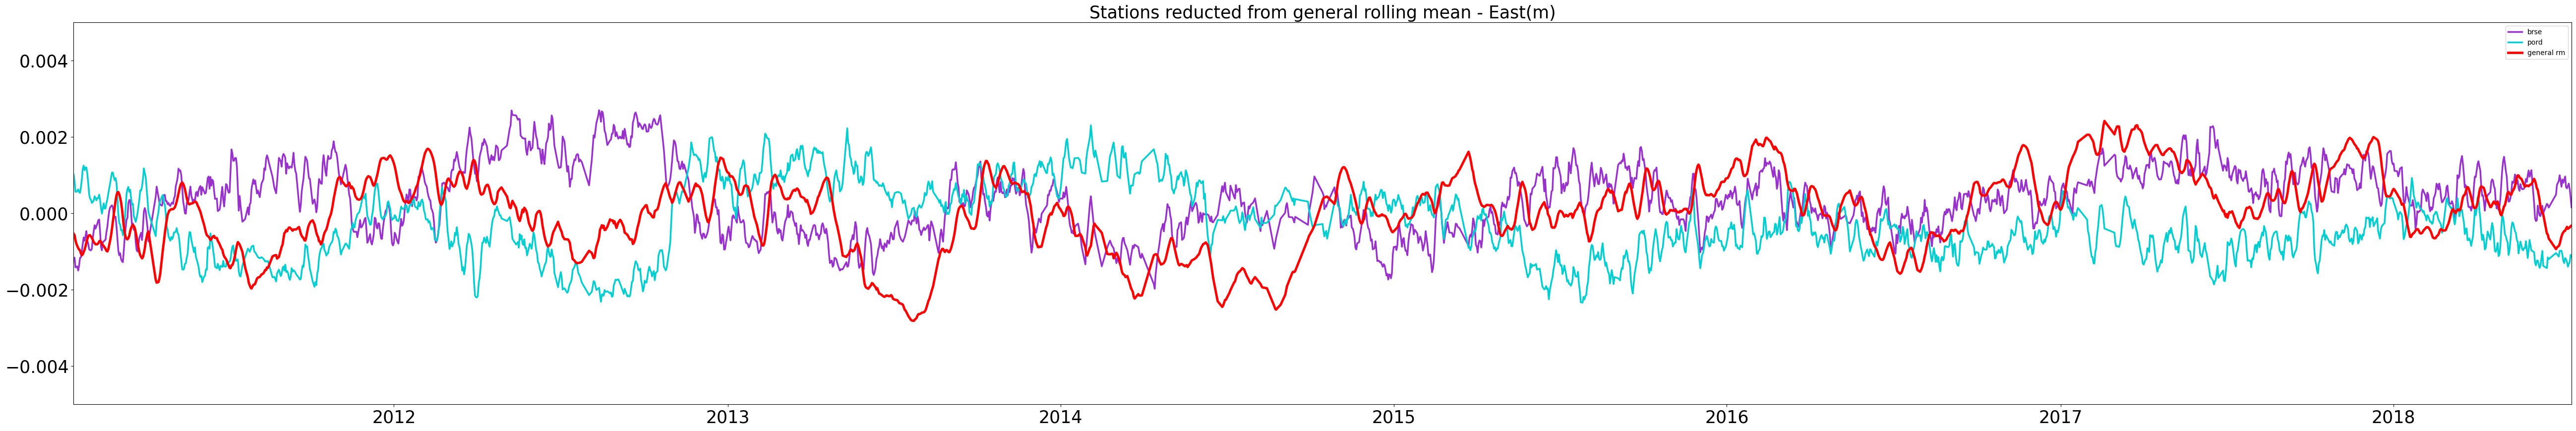

In [276]:
fig=plt.figure(figsize=(65,10))
plt.title('Stations reducted from general rolling mean - East(m)', fontsize = 25)

#plt.plot(brse_rolmeanE, color='darkgrey', label='brse', lw=2.5)
plt.plot(stations_reduced['brse_east(m)'], color='darkorchid', label='brse', lw=2.5)
plt.plot(stations_reduced['pord_east(m)'], color='darkturquoise', label='pord', lw=2.5)
#plt.plot(stations_reduced['mpra_east(m)'], color='darkorange', label='mpra', lw=2.5)
plt.plot(stations_copy['rolling_mean_stations'], color='red', label='general rm', lw=3.5)

plt.xlim(pd.Timestamp('2011-01-15'), pd.Timestamp('2018-07-15'))

plt.legend(loc='best')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(-0.005,0.005)

fl = 'stations_reduced_east.svg'
f = io.BytesIO()
plt.savefig(fl, format="svg")

plt.show()

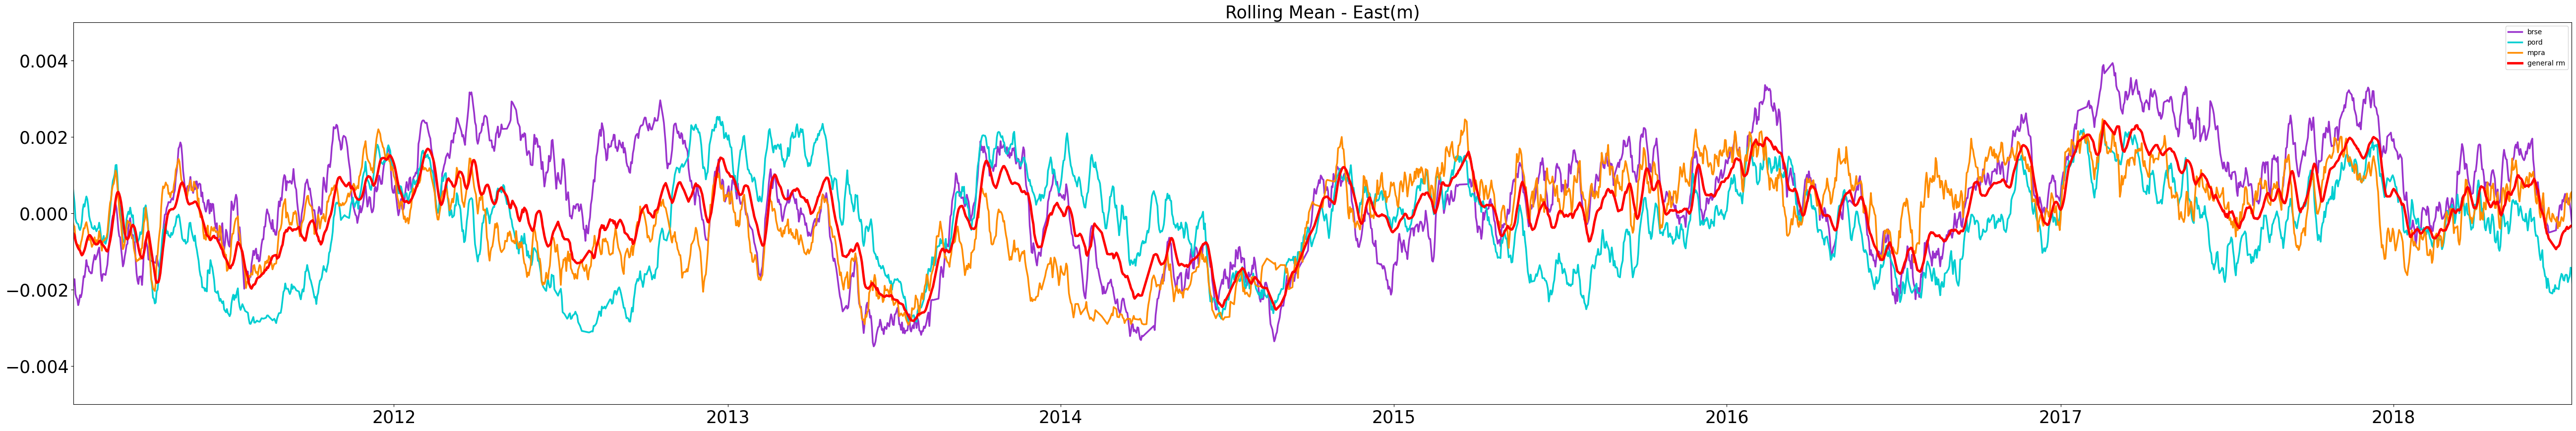

In [275]:
fig=plt.figure(figsize=(65,10))
plt.title('Rolling Mean - East(m)', fontsize = 25)

plt.plot(brse_rolmeanE, color='darkorchid', label='brse', lw=2.5)
plt.plot(pord_rolmeanE, color='darkturquoise', label='pord', lw=2.5)
plt.plot(mpra_rolmeanE, color='darkorange', label='mpra', lw=2.5)
plt.plot(stations_copy['rolling_mean_stations'], color='red', label='general rm', lw=3.5)



plt.xlim(pd.Timestamp('2011-01-15'), pd.Timestamp('2018-07-15'))
plt.legend(loc='best')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(-0.005,0.005)

fl = 'stations+rollingmean.svg'
f = io.BytesIO()
plt.savefig(fl, format="svg")

plt.show()

In [ ]:
fig=plt.figure(figsize=(65,10))

plt.xlim(pd.Timestamp('2011-01-15'), pd.Timestamp('2014-12-15'))
plt.plot(brse_rolmeanE, color='darkorchid', label='brse', lw=2.5)
plt.plot(brse_test, color='red', label='brse', lw=2.5)

fl = 'test.svg'
f = io.BytesIO()
plt.savefig(fl, format="svg")

plt.show()

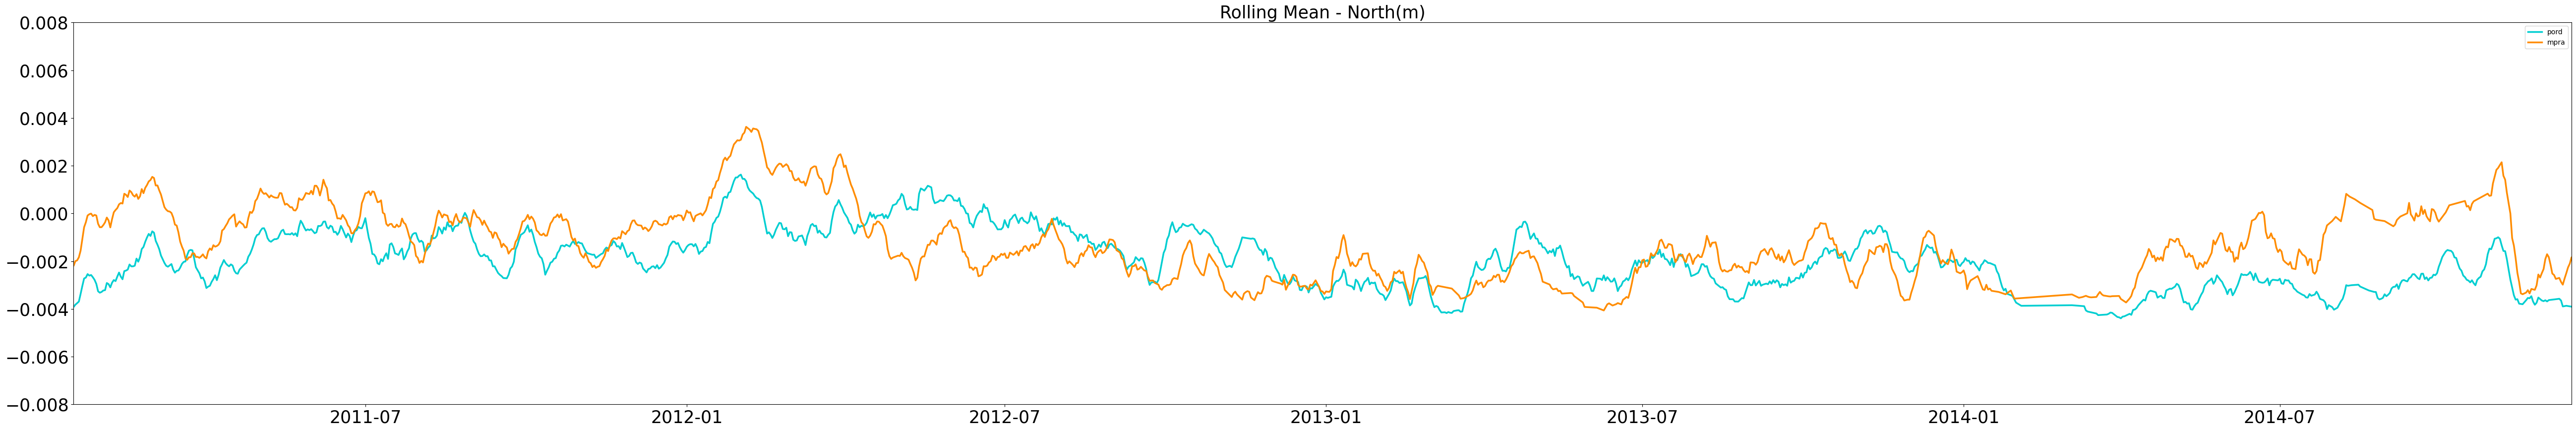

In [942]:
fig=plt.figure(figsize=(65,10))
plt.title('Rolling Mean - North(m)', fontsize = 25)

#plt.plot(brse_rolmeanN, color='darkorchid', label='brse', lw=2.5)
plt.plot(pord_rolmeanN, color='darkturquoise', label='pord', lw=2.5)
plt.plot(mpra_rolmeanN, color='darkorange', label='mpra', lw=2.5)
plt.xlim(pd.Timestamp('2011-01-15'), pd.Timestamp('2014-12-15'))
plt.legend(loc='best')

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(-0.008,0.008)

fl = 'brse_mpra_pord_north.svg'
f = io.BytesIO()
#plt.savefig(fl, format="svg")

plt.show()

#ACF and PACF plots - rolling mean:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(pord_rolmeanN, nlags=5)
lag_pacf = pacf(pord_rolmeanN, nlags=5, method='ols')

fig=plt.figure(figsize=(40,10))

#Plot ACF (q -> model MA): 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(pord_rolmeanN)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(pord_rolmeanN)),linestyle='--',color='gray')
plt.title('Autocorrelation Function', fontsize=25)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

#Plot PACF (p -> model AR): 
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(pord_rolmeanN)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(pord_rolmeanN)),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function', fontsize=25) 

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tight_layout()

#converting the index to datetime
brseE_df.index = pd.to_datetime(brseE_df.index)

#making sure that the index is in order
brseE_df.sort_index(inplace=True)

#setting the frequency as daily
brseE_df = brseE_df.asfreq('D')

#converting the index to datetime
brseE_noOut.index = pd.to_datetime(brseE_noOut.index)

#making sure that the index is in order
brseE_noOut.sort_index(inplace=True)

#setting the frequency as daily
brseE_noOut = brseE_noOut.asfreq('D')

#Auto-Regressive Integrated Moving Averages
model_ARIMA = ARIMA(pord_rolmeanN, order=(0, 1, 2))  
results_ARIMA = model_ARIMA.fit()  
modelA = results_ARIMA.fittedvalues

fig=plt.figure(figsize=(65,10))
#plt.plot(brseE_df, color='green', label='Original Time Series', linewidth = 0.5)
plt.plot(modelA,color='red', label='Fitted Values', linewidth= 1.2)

# Calculate Residual Sum of Squares (RSS)
residuals_ARIMA = brseE_noOut['__east(m)'] - results_ARIMA.fittedvalues
rss_ARIMA = np.sum(residuals_ARIMA**2, axis=0)

plt.title(f'Residual Sum of Squares (RSS): {rss_ARIMA:.4f}', fontsize=25)
plt.legend()
plt.xlabel('Time', fontsize=25)
plt.ylabel('East(m)', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(-0.005,0.005)
plt.xlim(pd.Timestamp('2011-01-15'), pd.Timestamp('2014-12-15'))

plt.show()

In [405]:
min_length = min(len(actualValues), len(predictedValues))
actualValues = brseE_df['__east(m)'].dropna()
predictedValues = modelA_df['__east(m)'].dropna()

commonIndex = actualValues.index.intersection(predictedValues.index)
actualValues = actualValues.loc[commonIndex]
predictedValues = predictedValues.loc[commonIndex]

if actualValues.empty or predictedValues.empty:
    raise ValueError("NaN values still present after dropping.")

print(min_length)

3057


In [452]:
arimaBrseE_mse = mean_squared_error(actualValues, predictedValues)
print(f"ARIMA - Mean Squared Error: {arimaBrseE_mse}")

arimaBrseE_rmse = np.sqrt(mean_squared_error(actualValues, predictedValues))
print(f"ARIMA - Root Mean Squared Error: {arimaBrseE_rmse}")

arimaBrseE_mae = mean_absolute_error(actualValues, predictedValues)
print(f"ARIMA - Mean Absolute Error: {arimaBrseE_mae}")

arimaBrseE_r2 = r2_score(actualValues, predictedValues)
print(f"ARIMA - R-squared (R2): {arimaBrseE_r2}")

ARIMA - Mean Squared Error: 1.6137397559606849e-06
ARIMA - Root Mean Squared Error: 0.0012703305695608072
ARIMA - Mean Absolute Error: 0.0009830144966464897
ARIMA - R-squared (R2): 0.28970651854068585
